In [ ]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time
from torchviz import make_dot
import hiddenlayer as hl
from collections import Counter
from imblearn.over_sampling import SMOTE

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

In [ ]:
# Data Transform
train_tfms = tt.Compose([tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor()])

In [3]:
# Load train, validation and test dataset
data_dir = os.getcwd()
train_file = os.path.join(data_dir, "../cancer_data_split/train")
val_file = os.path.join(data_dir, "../cancer_data_split/val")
test_file = os.path.join(data_dir, "../cancer_data_split/test")

train_ds = ImageFolder(train_file, train_tfms)
val_ds = ImageFolder(val_file, valid_tfms)
test_ds = ImageFolder(test_file, valid_tfms)

In [4]:
# Batch Size
batch_size = 100

In [5]:
######## Before Resampling

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

# train_records = Counter(train_dl.dataset.targets)
# val_records = Counter(val_dl.dataset.targets)
# test_records = Counter(test_dl.dataset.targets)

"""
print(train_records)
# Plot Train Records
plt.bar(train_records.keys(), train_records.values(), tick_label=list(train_records.keys()))
plt.title("Number of Training Images for Each Class (Before Resampling)")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.savefig("before_resampling")
"""

'\nprint(train_records)\n# Plot Train Records\nplt.bar(train_records.keys(), train_records.values(), tick_label=list(train_records.keys()))\nplt.title("Number of Training Images for Each Class (Before Resampling)")\nplt.xlabel("Classes")\nplt.ylabel("Number of Images")\nplt.savefig("before_resampling")\n'

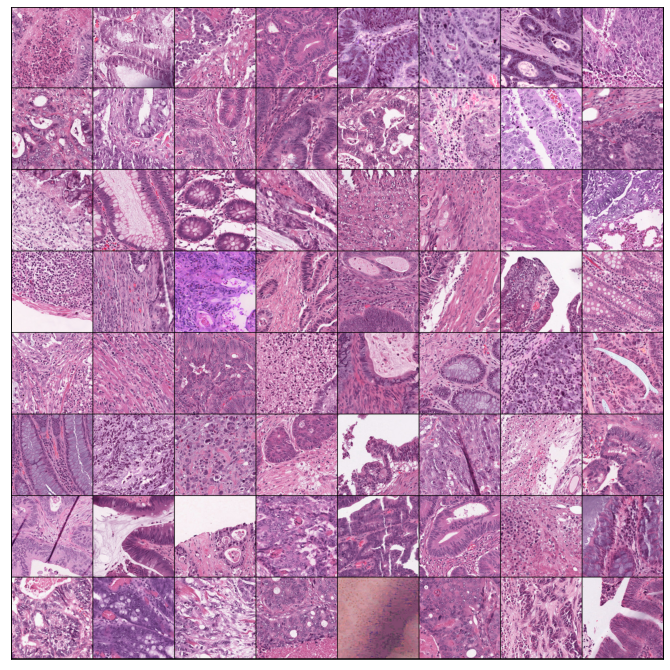

In [6]:
# See sample Images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [7]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [8]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        batch = to_device(batch, torch.device('cpu'))
        images, targets = batch
        
        # SMOTE Resampling
        reshaped_images = images.reshape([images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]])
        if (np.unique(targets, return_counts=True)[1][1]>6) and (np.unique(targets, return_counts=True)[1][0]>6):
            sampled_images, sampled_targets = SMOTE().fit_sample(reshaped_images, targets)
            images = torch.from_numpy(sampled_images.reshape([len(sampled_images), images.shape[1], images.shape[2], images.shape[3]]))
            targets = torch.from_numpy(sampled_targets)
        else:
            images = reshaped_images.reshape([len(reshaped_images), images.shape[1], images.shape[2], images.shape[3]])
            sampled_targets = targets.numpy()
            targets = targets
        
        # Training Step
        targets = torch.reshape(targets.type(torch.FloatTensor), (len(targets), 1))
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss, sampled_targets
    
    def validation_step(self, batch):
        images, targets = batch
        targets = torch.reshape(targets.type(torch.FloatTensor), (len(targets), 1))
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [9]:
class GastrointestinalCancerVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier._modules['6'] = nn.Linear(4096, 1)
    
    def forward(self, xb):
        return torch.relu(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [12]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    total_samples = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss, sampled_targets = model.training_step(batch)
            total_samples.extend(sampled_targets)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history, total_samples

In [13]:
model = to_device(GastrointestinalCancerVGG16(), device)

In [14]:
history = [evaluate(model, val_dl)]
history

C:\Users\WJuin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

In [ ]:
model.freeze()

In [ ]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
start_time = time.time()
history_new, samples = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

history = history + history_new
train_time = time.time() - start_time

In [ ]:
model.unfreeze()

In [ ]:
%%time
start_time = time.time()
history_new, samples = fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

history = history + history_new
train_time += time.time() - start_time

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs')
    plt.show()
    plt.savefig("ResNet34_SMOTE_resampling_scores_no_augmentation")

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()
    plt.savefig("ResNet34_SMOTE_resampling_losses_no_augmentation")

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()
    plt.savefig("ResNet34_SMOTE_resampling_lrs_no_augmentation")

In [ ]:
plot_scores(history)
plot_losses(history)
plot_lrs(history)